In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer    # Tensorflow un Tokenizer fonksiyonu
from tensorflow.keras.preprocessing.sequence import pad_sequences    # modele vereceğimiz squence lerin aynı boyutta olmasını sağlıyor.

In [2]:
df = pd.read_csv("tweet_data.csv")
df.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweetID     785916 non-null  int64 
 1   crDate      785916 non-null  object
 2   edInput     785916 non-null  int64 
 3   editor      785916 non-null  int64 
 4   engages     785916 non-null  int64 
 5   isApproved  785916 non-null  bool  
 6   isEdNeed    785916 non-null  bool  
 7   isRT        785916 non-null  bool  
 8   likes       785916 non-null  int64 
 9   photoUrl    277896 non-null  object
 10  retweets    785916 non-null  int64 
 11  rtUsID      785916 non-null  int64 
 12  text        785916 non-null  object
 13  topicName   785916 non-null  object
 14  usFlwrs     785916 non-null  int64 
 15  usID        785916 non-null  int64 
 16  usName      785916 non-null  object
 17  videoUrl    140491 non-null  object
dtypes: bool(3), int64(9), object(6)
memory usage: 92.2+ MB


In [4]:
df = df[(df["edInput"] != -1) & (df["edInput"] != 3)]

In [5]:
df['edInput'] = df['edInput'].replace(4, 1)

In [6]:
unique_values = df['edInput'].unique()
print(unique_values)

[1 2]


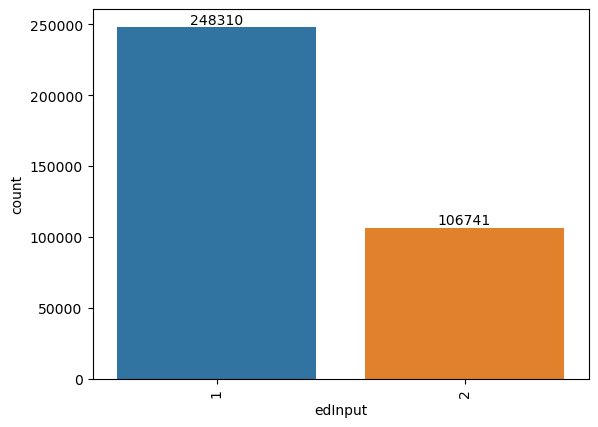

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.countplot(data =df, x ="edInput")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =90);

In [9]:
df["edInput"].value_counts()

1    248310
2    106741
Name: edInput, dtype: int64

In [10]:
pd.Series(df.edInput).value_counts(normalize=True)

1    0.699364
2    0.300636
Name: edInput, dtype: float64

In [11]:
df2 = df.copy()

In [12]:
df2["text"].head()

721     Which one would you choose? 👀 https://t.co/U0s...
1374             How it’s made. 😊 https://t.co/3XjOw4gIkg
1867    Smile, because it confuses people. Smile, beca...
2206                 𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw
2263    Baby Alpacas are so under appreciated. https:/...
Name: text, dtype: object

In [13]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import warnings

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
stop_words = stopwords.words('english')

In [17]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def cleaning(data):
    
    import re
    
    #1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()
    data = re.sub(r'^https?:\/\/.*[\r\n]*', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")    #don't gibi ifadeleri ' dan kurtarmış oluyoruz.
    
    #5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [18]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
cleaning_text = df2["text"].apply(cleaning)       #cleaning fonksiyonumu apply ile tüm text ime uyguluyorum
cleaning_text.head()

721                                      one would choose
1374                                                 made
1867    smile confuses people smile easier explaining ...
2206                                         𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡
2263                              baby alpaca appreciated
Name: text, dtype: object

In [20]:
df2["text"] = cleaning_text

In [21]:
X = df['text'].values    # Deep Learning de datayı arraya çevirmek için .values ekliyoruz.
y = df['edInput'].values

In [22]:
num_words = 15000 # corpusta geçen en fazla kullanılan ilk 15.000 kelimeyi(tokeni) alacağız gerisini yok sayacağız. 
# None değeri atanırsa tüm kelimeler dikkate alınır.
tokenizer = Tokenizer(num_words=num_words) #filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890' 

In [23]:
tokenizer.fit_on_texts(X)     # Tensorflow un kendisinin geliştirdiği Tokenizer fonksiyonu... #otomatik olarak lower yapıyor.

In [24]:
tokenizer.word_index

{'t': 1,
 'co': 2,
 'https': 3,
 'the': 4,
 'to': 5,
 'a': 6,
 'of': 7,
 'and': 8,
 'in': 9,
 'is': 10,
 'you': 11,
 'for': 12,
 'on': 13,
 'this': 14,
 'with': 15,
 'by': 16,
 'it': 17,
 'that': 18,
 'are': 19,
 'at': 20,
 'your': 21,
 'be': 22,
 'from': 23,
 'i': 24,
 'have': 25,
 'more': 26,
 'as': 27,
 'new': 28,
 'will': 29,
 'an': 30,
 'our': 31,
 'what': 32,
 'we': 33,
 'how': 34,
 'not': 35,
 'can': 36,
 'has': 37,
 'if': 38,
 'but': 39,
 'about': 40,
 'one': 41,
 'was': 42,
 'all': 43,
 'who': 44,
 'out': 45,
 'up': 46,
 'my': 47,
 'his': 48,
 'just': 49,
 'get': 50,
 'when': 51,
 'here': 52,
 'people': 53,
 'do': 54,
 'now': 55,
 'life': 56,
 'like': 57,
 'so': 58,
 'their': 59,
 'after': 60,
 'they': 61,
 'or': 62,
 'time': 63,
 'its': 64,
 'day': 65,
 'he': 66,
 'these': 67,
 'quote': 68,
 'than': 69,
 'first': 70,
 'art': 71,
 'us': 72,
 'make': 73,
 'no': 74,
 'into': 75,
 'trump': 76,
 'want': 77,
 'see': 78,
 'world': 79,
 'me': 80,
 'her': 81,
 "it's": 82,
 'over': 83,

In [25]:
len(tokenizer.word_index)   #  ilk 15.000 ini eğitimde modele sokacağız. 

531462

In [26]:
X_num_tokens = tokenizer.texts_to_sequences(X)   # TEXT IMI TOKENIZE IŞLEMİNE TABİ TUT.

In [37]:
X_num_tokens[105]

[2898,
 23,
 104,
 454,
 1756,
 76,
 8,
 70,
 1843,
 5491,
 76,
 7508,
 14917,
 19,
 352,
 1043,
 3428,
 419,
 9,
 59,
 1110,
 538,
 2898,
 1383,
 9,
 4,
 1750,
 1814,
 7,
 4,
 225,
 124,
 9,
 1079,
 612,
 827,
 1110,
 225,
 124,
 143,
 16,
 6216,
 14220,
 3,
 1,
 2]

In [29]:
df2.head(11)

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
721,1070970722598707200,2018-12-07 09:18:12,1,5001,5137,True,True,False,4180,https://pbs.twimg.com/media/DtzaMK_W4AE6Vle.jpg,957,-1,one would choose,Fashion,37293,1061553474918342656,Gentleman’s style,NaN
1374,1070981773616648193,2018-12-07 10:02:07,1,5003,52650,True,True,True,36349,NaN,16301,781427301472874497,made,Interesting,34897,994950431234080768,Satisfying Slime,https://video.twimg.com/ext_tw_video/107097772...
1867,916500037818916866,2017-10-07 03:06:51,2,5003,63872,False,True,True,39698,NaN,24174,821811651393495040,smile confuses people smile easier explaining ...,Interesting,966840,482658470,Tips & Tricks Ideas ✌,NaN
2206,1071135340696625152,2018-12-07 20:12:20,1,5001,1714,True,True,False,1261,https://pbs.twimg.com/media/Dt1v6O9XgAIXOrR.jpg,453,-1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡,Art,33308,762649146,𝐴𝑟𝑡.,NaN
2263,1071141175606829056,2018-12-07 20:35:31,1,5001,62062,True,True,False,49073,NaN,12989,-1,baby alpaca appreciated,Animal,1052924,2828212668,Nature is Amazing ☘️,https://video.twimg.com/ext_tw_video/107114109...
2389,1071156784524455936,2018-12-07 21:37:33,2,5003,33972,False,True,False,26549,https://pbs.twimg.com/media/Dt2DZ5uVsAAEK1Y.jpg,7423,-1,felt cute might delete later,Animal,609253,372525089,animals 🐕,NaN
2583,1070810239379730432,2018-12-06 22:40:30,2,5003,75013,False,True,True,58739,https://pbs.twimg.com/media/DtxIPC0U0AEqlCN.jpg,16274,1048335020392239105,sunflower pendant,Interesting,93675,713581625561382912,femme fatale,NaN
2619,1070830568970092545,2018-12-07 00:01:17,2,5003,20936,False,True,True,16017,NaN,4919,372525089,need one,Animal,18263,1497325416,Naughty or Nice,NaN
2660,1070988807514640384,2018-12-07 10:30:04,1,5001,78403,True,True,True,58396,NaN,20007,769254092581449728,people idea compassion entail complete disrega...,Personal Development,18855031,20609518,Dalai Lama,NaN
2779,1071229126269435906,2018-12-08 02:25:00,1,5003,30911,True,True,False,26151,NaN,4760,-1,big hop energy bferber,Animal,9875512,568825492,Cute Emergency,https://video.twimg.com/ext_tw_video/104258538...


In [32]:
num_tokens = [len(tokens) for tokens in X_num_tokens] # X_num_tokens deki (yorumlardaki) her bir tokeni al ve say...
num_tokens = np.array(num_tokens)   # mean, max etc gibi işlemleri daha rahat yapabilmek için array a çevirdik.

In [33]:
num_tokens

array([ 9,  7, 18, ..., 11, 28, 18])

In [34]:
num_tokens.mean()

19.341950874663077

In [35]:
num_tokens.max()

89

In [36]:
num_tokens.argmax() # listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

232976

In [38]:
X_num_tokens[232976]

[8311,
 903,
 5,
 50,
 84,
 12882,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241,
 5446,
 6241]

In [39]:
len(X_num_tokens[232976])

89

In [58]:
max_tokens = 65  # Maksimum belirlemek istediğiniz belirli bir değeri kullanabilirsiniz
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)


In [59]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)   # sabitleme 

In [60]:
X_pad.shape

(355051, 65)

In [61]:
np.array(X_num_tokens[400])

array([   51,    11,   618,    20,     6,  5336,   102,    10,   520,
           6,  1261,     7,   710,    11,   286,     6,   753,   186,
         578,    32,    36,    24,   205,    52,    34,    36,    24,
          22,     7,   873,     5,    14,   296,    14,  2065, 13920,
       13921, 11486,   618,     3,     1,     2])

In [62]:
X_pad[400]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,    51,    11,   618,    20,
           6,  5336,   102,    10,   520,     6,  1261,     7,   710,
          11,   286,     6,   753,   186,   578,    32,    36,    24,
         205,    52,    34,    36,    24,    22,     7,   873,     5,
          14,   296,    14,  2065, 13920, 13921, 11486,   618,     3,
           1,     2])

In [63]:
np.array(X_num_tokens[232976])

array([ 8311,   903,     5,    50,    84, 12882,  6241,  5446,  6241,
        5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,
        6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,
        5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,
        6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,
        5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,
        6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,
        5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,
        6241,  5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241,
        5446,  6241,  5446,  6241,  5446,  6241,  5446,  6241])

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=0)

In [66]:
model = Sequential()

In [67]:
embedding_size = 50   # EMBEDDING SIZE İLE OYNAYARAK OVERFITTING E ENGEL OLABİLİRİZ.

In [53]:
!pip install -U numpy==1.19.5 

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [202 lines of output]
  setup.py:67: RuntimeWarning: NumPy 1.19.5 may not yet support Python 3.10.
    warnings.warn(
  Running from numpy source directory.
  setup.py:480: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
    run_build = parse_setuppy_commands()
  Processing numpy/random\_bounded_integers.pxd.in
  Processing numpy/random\bit_generator.pyx
  Processing numpy/random\mtrand.pyx
  Processing numpy/random\_bounded_integers.pyx.in
  Processing numpy/random\_common.pyx
  Processing numpy/random\_generator.pyx
  Processing numpy/random\_mt19937.pyx
  Processing numpy/random\_pcg64.pyx
  Processing numpy/random\_philox.pyx
  Processing numpy/random\_sfc64.pyx
  Cythonizing sources
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying fro


  Using cached numpy-1.19.5.zip (7.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


In [68]:
model.add(Embedding(input_dim=num_words,   # İLK 15.000 TOKENI AL..
                    output_dim=embedding_size,    # KAÇ BOYUTTA OLACAĞINI İFADE EDİYOR (50 BOYUT)
                    input_length=max_tokens))   # HER BİR YORUMUN UZUNLUĞU (61 TOKEN)

model.add(Dropout(0.2))   # 50 BOYUTLU VEKTÖRÜN YÜZDE 20 SİNE KADAR KAPATIR..

model.add(GRU(units=48, return_sequences=True))    # LSTM DE KULLANILABİLİR..    UNITS= VEKTÖRÜ 48 BOYUTA DÜŞÜRÜR 
model.add(Dropout(0.2))         # RETURN SEQUENCE= TRUE OLDUĞU ZAMAN... BİR SONRAKİ HIDDEN LAYER A GÖNDERİLEN BİLGİLER TOPLU OLARAK AKTARILIR..  

#model.add(GRU(units=24, return_sequences=True))
#model.add(Dropout(0.2))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))

In [69]:
optimizer = Adam(learning_rate=0.01)    # OVERFITTING İÇİN DEĞİŞİKLİK YAPABİLİRİZ.

In [83]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Precision'])

In [84]:
model.summary() 
# 3 x (n2 + nm + 2n) m= input, n= output
# (48*48 + 100*48 +2*48)*3 ==> m = 50, n = 48
# (24*24 + 48*24  +2*24)*3 ==> m =  48, n = 24
# (12*12 + 24*12  +2*12)*3 ==> m =  24, n = 12

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 65, 50)            750000    
                                                                 
 dropout_2 (Dropout)         (None, 65, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 65, 48)            14400     
                                                                 
 dropout_3 (Dropout)         (None, 65, 48)            0         
                                                                 
 gru_3 (GRU)                 (None, 12)                2232      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 766,645
Trainable params: 766,645
Non-tr

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max",   #mode= auto da trendi takip eder.             
                           verbose=1, patience = 2, restore_best_weights=True)

In [73]:
from sklearn.utils import class_weight     # DENGESİZ BİR DATA OLDUĞU İÇİN YENİ BİR AĞIRLANDIRMA YAPILIYOR.
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pd.Series(classes_weights).unique()

array([1.66313398, 0.71493655])

In [74]:
model.fit(X_train, y_train, epochs=10, batch_size=256, sample_weight= classes_weights,
         validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/10
1110/1110 [==============================] - 190s 167ms/step - loss: -38.2426 - precision: 1.0000 - val_loss: -44.7156 - val_precision: 1.0000
Epoch 2/10
1110/1110 [==============================] - 175s 158ms/step - loss: -110.2094 - precision: 1.0000 - val_loss: -87.8709 - val_precision: 1.0000
Epoch 3/10
1110/1110 [==============================] - 167s 151ms/step - loss: -181.9724 - precision: 1.0000 - val_loss: -131.0360 - val_precision: 1.0000
Epoch 4/10
1110/1110 [==============================] - 167s 151ms/step - loss: -253.7865 - precision: 1.0000 - val_loss: -174.2103 - val_precision: 1.0000
Epoch 5/10
1110/1110 [==============================] - 174s 157ms/step - loss: -325.6976 - precision: 1.0000 - val_loss: -217.4621 - val_precision: 1.0000
Epoch 6/10
1110/1110 [==============================] - 188s 169ms/step - loss: -397.5330 - precision: 1.0000 - val_loss: -260.6235 - val_precision: 1.0000
Epoch 7/10
1110/1110 [==============================] - 178s 160ms/

In [76]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,precision,val_loss,val_precision
0,-38.242649,1.0,-44.715641,1.0
1,-110.209442,1.0,-87.870949,1.0
2,-181.972351,1.0,-131.035995,1.0
3,-253.786530,1.0,-174.210297,1.0
4,-325.697571,1.0,-217.462051,1.0


<Axes: >

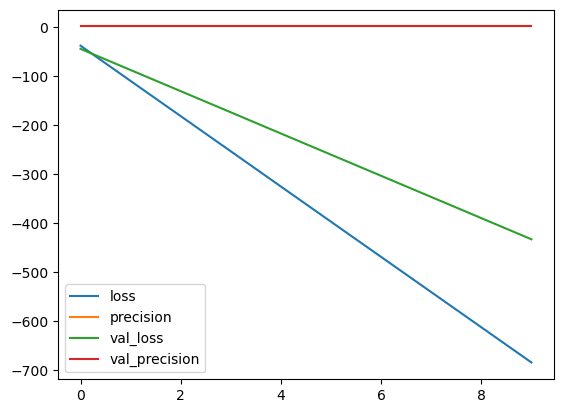

In [77]:
model_loss.plot()

In [78]:
model.evaluate(X_train, y_train)

8877/8877 [==============================] - 176s 20ms/step - loss: -433.3784 - precision: 1.0000


[-433.3783874511719, 1.0]

In [79]:
model.evaluate(X_test, y_test)

2220/2220 [==============================] - 56s 25ms/step - loss: -433.3634 - precision: 1.0000


[-433.3634338378906, 1.0]

In [80]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

8877/8877 [==============================] - 195s 22ms/step
[[198647      0]
 [ 85393      0]]
-------------------------------------------------------


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.70      1.00      0.82    198647
           2       0.00      0.00      0.00     85393

    accuracy                           0.70    284040
   macro avg       0.35      0.50      0.41    284040
weighted avg       0.49      0.70      0.58    284040



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

2220/2220 [==============================] - 59s 27ms/step
[[49663     0]
 [21348     0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           1       0.70      1.00      0.82     49663
           2       0.00      0.00      0.00     21348

    accuracy                           0.70     71011
   macro avg       0.35      0.50      0.41     71011
weighted avg       0.49      0.70      0.58     71011



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2220/2220 [==============================] - 54s 24ms/step


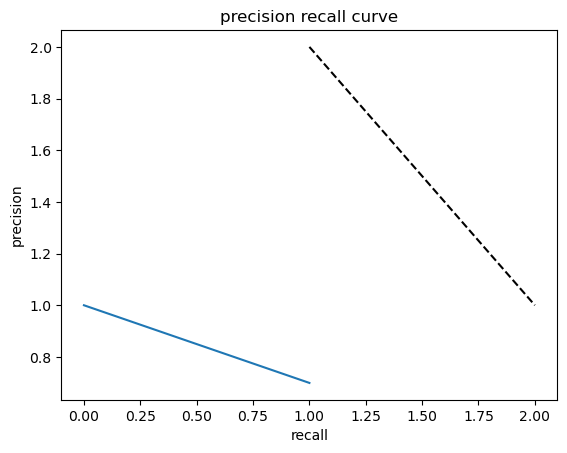

In [86]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label=1)

y_pred_proba = model.predict(X_test)

plt.plot([1,2],[2,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [87]:
average_precision_score(y_test, y_pred_proba)

0.6993705200602723